In [1]:
import math
import numpy as np
import sys
import pandas as pd
from scipy import signal

df = pd.read_csv('atqa_manresa_smart_container.csv', skiprows=4)
import matplotlib.pyplot as plt

In [2]:
import os
os.getcwd()

'/mnt/d/F/TFM/FPGA_NFC_transceiver/analysis'

In [3]:
#%pip install numpy pandas matplotlib


In [4]:
import py4hw

In [5]:
#%pip install py4hw

In [6]:
#%pip install scipy

In [7]:
from scipy.signal import kaiserord, lfilter, firwin, freqz
# order/dectector/coefficient/freq

# FIR filter
def highpass_filter(Fs, cutoff, db, ntaps, ripple_db):
    nyq_rate = Fs/2
    width = (0.1 * cutoff) 
    N, beta = kaiserord(db, width) #order/N:number of taps
    
    if (N > ntaps):
        print('WARNING: the kaiser window would require {} taps (more than the {} requested)'.format(N, ntaps))
    
    cutoff_hz = cutoff/nyq_rate #range of freq
    
    # Use firwin with a Kaiser window to create a lowpass FIR filter.
    taps = firwin(ntaps, cutoff_hz, window=('kaiser', beta), pass_zero='highpass')
    return taps

In [8]:
from scipy.signal import kaiserord, lfilter, firwin, freqz
# order/dectector/coefficient/freq

def lowpass_filter(Fs, cutoff, db, ntaps, ripple_db):
    nyq_rate = Fs/2
    width = (0.1 * cutoff) 
    N, beta = kaiserord(db, width) #order/N:number of taps
    
    if (N > ntaps):
        print('WARNING: the kaiser window would require {} taps (more than the {} requested)'.format(N, ntaps))
    
    cutoff_hz = cutoff/nyq_rate #range of freq
    
    # Use firwin with a Kaiser window to create a lowpass FIR filter.
    taps = firwin(ntaps, cutoff_hz, window=('kaiser', beta), pass_zero='lowpass')
    #taps = taps / np.sum(taps)
    
    return taps

In [9]:
# Hardware multiplier of "r/each tap = input signal a × constant coefficients coeff"

class MultSignalByCoeff(py4hw.Logic):
    def __init__(self, parent, name, a, coeff, r):
        super().__init__(parent, name)
        
        self.addIn('a', a)
        self.addOut('r', r)
        
        w = a.getWidth()
        
        assert(w == r.getWidth())
        
        # inside signal
        sa = self.wire('sa', w) #The sign extension of a
        sr = self.wire('sr', 2*w) #multip result
        k = self.wire('k', w) #constant 2 w-1(index) 
        b = self.wire('b', w) 
        
        py4hw.Constant(self, 'k', 1<<(w-1), k) # w=16,k=1<<15=32768
        
        py4hw.Constant(self, 'coeff', int((1<<(w-1)) * coeff), b) #b = coeff × 2^(w−1)
        
        py4hw.SignedSub(self, 'sa', a, k, sa)
        py4hw.SignedMul(self, 'sr', sa, b, sr) #sr = sa(from a) × b(from coeff)
        
        py4hw.ShiftRightConstant(self, 'r', sr, w, r) #r = (a × coeff)

In [10]:
class highpassFilter(py4hw.Logic):
    def __init__(self, parent, name, Fs, cutoff, db, ntaps, x, r):
        super().__init__(parent, name)
        
        self.addIn('x', x)
        self.addOut('r', r)
        
        w = x.getWidth()
        z = [x]
        last = x
        
        # create the registers for z-1
        for i in range(ntaps-1):
            nwire = 'z_{}'.format(i+1)
            wire = self.wire(nwire, w)
            z.append(wire)
            py4hw.Reg(self, nwire, d=last, q=wire)
            last = wire
            
        taps = highpass_filter(Fs, cutoff, db, ntaps,db) #h[0], h[1], … h[N-1] FIR coeff
            
        for i in range(ntaps):
            pname = 'p{}'.format(i)
            p = self.wire(pname, w)
            
            MultSignalByCoeff(self, pname, z[i], taps[i], p) #p0 = z[0] × h[0]p0 = z[0] × h[0]... multi
            if (i == 0):
                last = p
            else:
                aname = 'a{}'.format(i)
                a = self.wire(aname, w)
                AddSignals(self, aname, p, last, a)
                last = a
                
        py4hw.Buf(self, 'buf', last, r) #r = Σ z[i] × h[i] plus

In [11]:
class lowpassFilter(py4hw.Logic):
    def __init__(self, parent, name, Fs, cutoff, db, ntaps, x, r):
        super().__init__(parent, name)
        
        self.addIn('x', x)
        self.addOut('r', r)
        
        w = x.getWidth()
        z = [x]
        last = x
        
        # create the registers for z-1
        for i in range(ntaps-1):
            nwire = 'z_{}'.format(i+1)
            wire = self.wire(nwire, w)
            z.append(wire)
            py4hw.Reg(self, nwire, d=last, q=wire)
            last = wire
            
        taps = lowpass_filter(Fs, cutoff, db, ntaps,db) #h[0], h[1], … h[N-1] FIR coeff
            
        for i in range(ntaps):
            pname = 'p{}'.format(i)
            p = self.wire(pname, w)
            
            MultSignalByCoeff(self, pname, z[i], taps[i], p) #p0 = z[0] × h[0]p0 = z[0] × h[0]... multi
            if (i == 0):
                last = p
            else:
                aname = 'a{}'.format(i)
                a = self.wire(aname, w)
                AddSignals(self, aname, p, last, a)
                last = a
                
        py4hw.Buf(self, 'buf', last, r) #r = Σ z[i] × h[i] plus

In [12]:
raw_data = df[' uart2nfca_system_top:u_uart2nfca_system|nfca_controller:u_nfca_controller|nfca_rx_dsp:u_nfca_rx_dsp|rx_raw_data']

print(raw_data[1])
def conv(s):
    try:
        v = int(s,2)
    except:
        v = 0
    return v
    
def to_signed(v, w=16):
    if v >= (1 << (w-1)):
        return v - (1 << w)
    return v

iraw_data = [to_signed(conv(x), 16) for x in raw_data[1:]]
rx = np.array(iraw_data, dtype=np.int32)


 100101010011


In [13]:
class AddSignals(py4hw.Logic):
    def __init__(self, parent, name, a, b, r):
        super().__init__(parent, name)
        
        self.addIn('a', a)
        self.addIn('b', b)
        self.addOut('r', r)
        
        sa = self.wire('sa', a.getWidth())
        sb = self.wire('sb', b.getWidth())
        sr = self.wire('sr', r.getWidth())
        k = self.wire('k', r.getWidth())
        
        py4hw.Constant(self, 'k', 1<<15, k)
        
        py4hw.SignedSub(self, 'sa', a, k, sa)
        py4hw.SignedSub(self, 'sb', b, k, sb)
        
        py4hw.Add(self, 'sr', sa, sb, sr)
        py4hw.Add(self, 'r', sr, k, r)
        

In [14]:
#like SignalTap 
class StreamCapture(py4hw.Logic):
    def __init__(self, parent, name, x):
        super().__init__(parent, name)
        self.x = self.addIn('x', x)
        
        self.data = []
        
    def clock(self):
        self.data.append(self.x.get())

    def clear(self):
        self.data = []

class StreamCaptureSigned(py4hw.Logic):
    def __init__(self, parent, name, x):
        super().__init__(parent, name)
        self.x = self.addIn('x', x)
        
        self.data = []
        
    def clock(self):
        self.data.append(py4hw.IntegerHelper.c2_to_signed(self.x.get(), self.x.getWidth()))

    def clear(self):
        self.data = []        

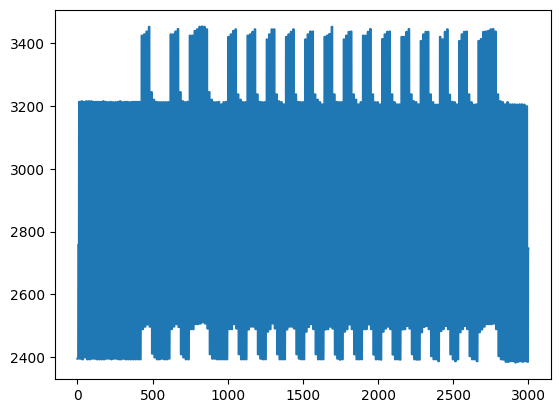

In [15]:
plt.plot(rx[2000:5000])
plt.show()

In [16]:
from py4hw import Logic
from py4hw import Wire
from py4hw import Sign, Neg, Mux2

In [17]:
from py4hw.logic.arithmetic import Abs

In [18]:
class Abs(Logic):
    """
    Absolute value
    """
    def __init__(self, parent, name: str, a: Wire, r: Wire, inverted:Wire=None):
        """
        Creates ans absolute value circuit r = abs(a), inverted=sign(a)

        Parameters
        ----------
        parent : TYPE
            parent.
        name : str
            name.
        a : Wire
            input.
        r : Wire
            absolute value of a.
        inverted : Wire, optional
            indicates wether a was negated. The default is None.

        Returns
        -------
        None.

        """
        super().__init__(parent, name)
        self.a = self.addIn("a", a)
        self.r = self.addOut("r", r)

        if not(inverted is None):
            s = self.addOut('inverted', inverted)
        else:
            s = self.wire('sign')

        neg = self.wire('neg', a.getWidth())
        Sign(self, 'sign', a, s)
        Neg(self, 'neg', a, neg)
        Mux2(self, 'mux', s, a, neg, r)
        
    def structureName(self):
        if (self.a.getWidth() == self.r.getWidth()):
            return f'Abs{self.a.getWidth()}'
        else:
            return f'Abs{self.a.getWidth()}_{self.r.getWidth()}'


In [19]:
#help(py4hw.Comparator)
from py4hw import Comparator

In [20]:
print(np.max(rx), type(rx.astype(int)[0]))

3453 <class 'numpy.int64'>


type <class 'int'>


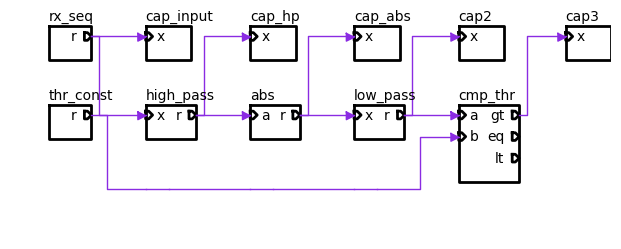

In [21]:
hw = py4hw.HWSystem()
hlp = py4hw.LogicHelper(hw)

dur = 0.001 #time
Fs = 13.56e6
#freq1=847.5
amplitude = 0.5

x0 = hw.wire('x0', 16)
x = hw.wire('x', 16)

db = 60
ntaps = 31
Rb=106e3
cutoff= Rb*9

# INPUT = rw_w
rx_w = hw.wire('rx_w', 16)
rx_int = [int(x) for x in rx]
py4hw.Sequence(hw, 'rx_seq', rx_int, rx_w)
print('type', type(rx_int[0]))

cap_input = StreamCapture(hw, 'cap_input', rx_w) 
#rx_seq

# HPF = x
hp_w = hw.wire('hp_w', 16)
hp = highpassFilter(hw, 'high_pass', Fs, cutoff, db, ntaps, rx_w, x)
cap_hp = StreamCaptureSigned(hw, 'cap_hp', x)
#after high_pass filter

# HPF = abs_w
abs_w = hw.wire('abs_w', 18)
abs1 = Abs(hw, 'abs', x, abs_w)
cap_abs = StreamCapture(hw, 'cap_abs', abs_w)

# LPF = lp_w
cutoff=106e3*0.5
ntaps=31
lp_w = hw.wire('lp_w', 18)
lp = lowpassFilter(hw,'low_pass',Fs, cutoff, db, ntaps, abs_w, lp_w)
cap2 = StreamCapture(hw, 'cap2',lp_w)
#after abs+low_pass filter

# threshold
bit_w = hw.wire('bit_w',1)
thr_const_w = hw.wire('thr_const_w', 18)
#env = np.array(cap_lp.data)
#envelope = lfilter(taps_lp, 1.0, rectified)
TH_VAL =42.74
py4hw.Constant(hw,'thr_const', int(TH_VAL), thr_const_w)
#Threshold(hw, 'threshold', lp_w, thr_const_w, bit_w)
gt = hw.wire('gt')
eq = hw.wire('eq')
lt = hw.wire('lt')

py4hw.Comparator(
    hw, 'cmp_thr',
    lp_w, thr_const_w,
    gt, eq, lt
)
cap3 = StreamCapture(hw, 'cap3',gt)

sch = py4hw.Schematic(hw)
sch.drawAll()
#plt.savefig('topFIR.png')

In [22]:
hw.getSimulator().clk(2000)
cap_input.clear()
cap_abs.clear()
cap_hp.clear()
cap2.clear()
cap3.clear()
hw.getSimulator().clk(5000-2000)

#print(rx_w.get())
#rx[:10].astype(int)

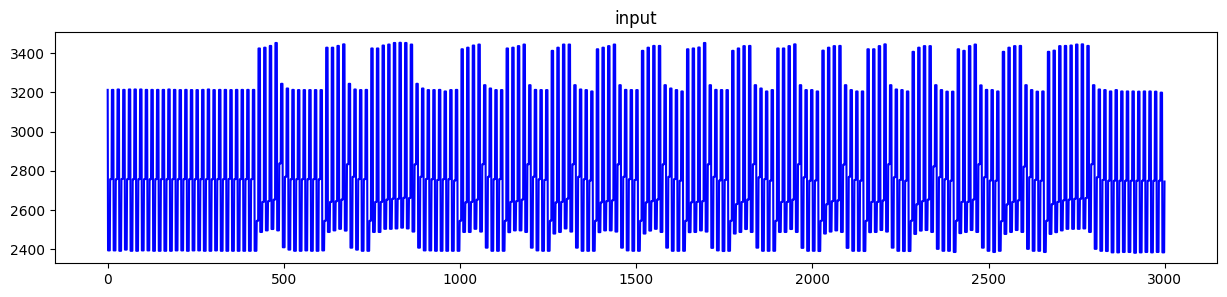

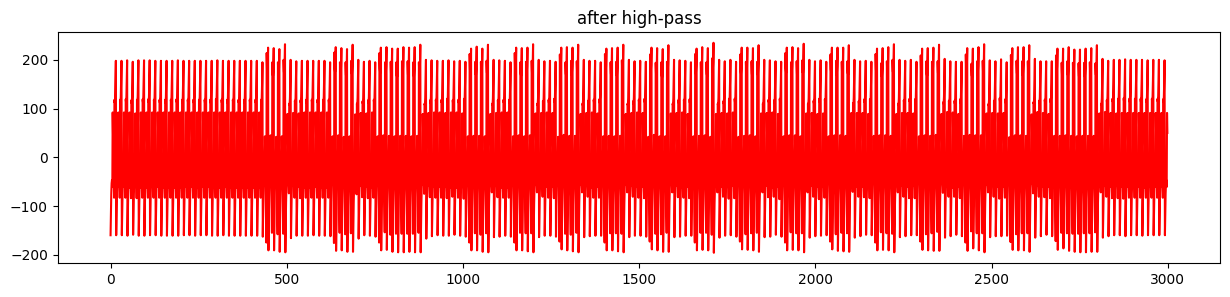

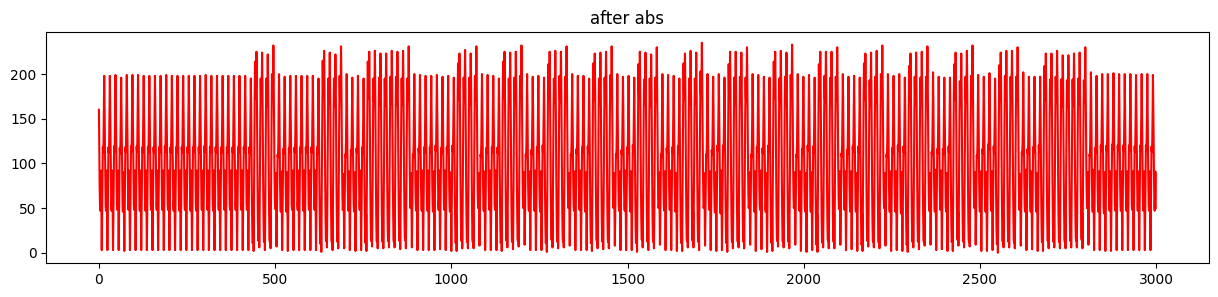

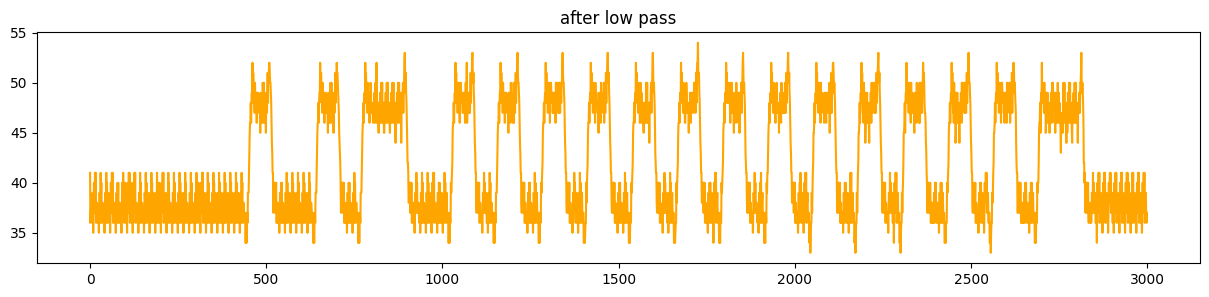

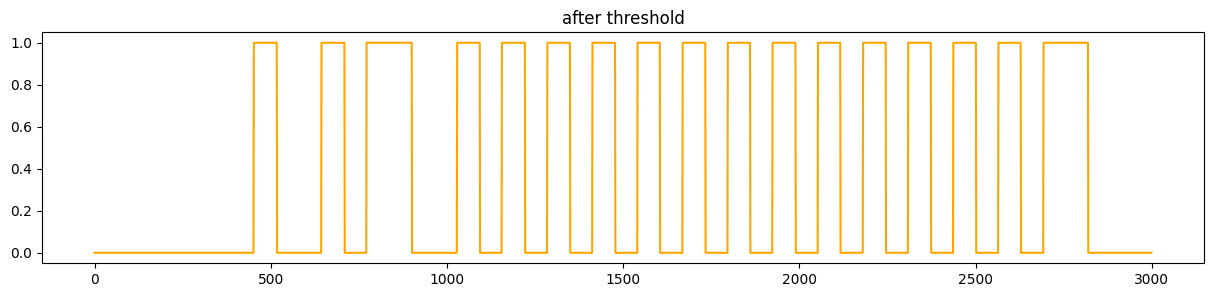

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,3))
plt.plot(cap_input.data, color='blue')
#plt.savefig('filteredsignal.png')
plt.title('input')
plt.show()

plt.figure(figsize=(15,3))
plt.plot(cap_hp.data, color='red')
#plt.savefig('filteredsignal.png')
plt.title('after high-pass')
plt.show()

plt.figure(figsize=(15,3))
plt.plot(cap_abs.data, color='red')
#plt.savefig('filteredsignal.png')
plt.title('after abs')
plt.show()

plt.figure(figsize=(15,3))
plt.plot(cap2.data, color='orange')
plt.title('after low pass')
#plt.savefig('filteredsignal.png')
plt.show()

plt.figure(figsize=(15,3))
plt.plot(cap3.data, color='orange')
plt.title('after threshold')
#plt.savefig('filteredsignal.png')
plt.show()

In [25]:
#print(cap3.data)

In [26]:
%store cap3

Proper storage of interactively declared classes (or instances
of those classes) is not possible! Only instances
of classes in real modules on file system can be %store'd.



In [27]:
seq = cap3.data    
print(type(seq), len(seq))

import numpy as np
np.save("cap3_seq.npy", seq)

<class 'list'> 3000


## Next Steps
Use py4hw edge detector to detect 0->1 transitions in the bits signal. This should reset the modulo counter. The second time that the transition happens you ignore it.

and then sampling the data every 32 cycles. You could use a py4hw ModuloCounter  and a register with enable signal to sample the value.

and then convert data with manchester encoding

In [28]:
from py4hw import HWSystem, ModuloCounter, EdgeDetector,Constant 
from py4hw.logic.storage import Reg 
from py4hw.logic.bitwise import And2, Not, Xor2,Mux2
hw = HWSystem()

#State definition 
WAIT_FIRST_EDGE = 0 
SAMPLING = 1 
ENCODING = 2
state = hw.wire('state', 2) 
next_state = hw.wire('next_state', 2)
Reg(hw, 'state_reg', d=next_state, q=state) 

#Input 
#bits=gt 
bits = hw.wire('bits', 1) 
data_in = hw.wire('data_in', 8) 
edge_out = hw.wire('edge_out', 1) 
EdgeDetector(hw, 'edge_det', a=bits, r=edge_out, direction='pos') 
edge_count = hw.wire('edge_count', 1) 
edge_count_next = hw.wire('edge_count_next', 1) 
not_edge = hw.wire('not_edge', 1) 
Not(hw, 'not1', edge_count, not_edge) 
Mux2(hw, 'mux_edge', edge_count, not_edge, edge_out, edge_count_next)

# sample counter 
sample_cnt = hw.wire('sample_cnt', 6) 
sample_reset = hw.wire('sample_reset', 1) 
sample_trigger = hw.wire('sample_trigger', 1) 
one = hw.wire('one', 1) 
Constant(hw, 'one', 1, one)

ModuloCounter(hw, 'sample_counter', mod=64, reset=sample_reset, inc=one, q=sample_cnt, carryout=sample_trigger) 
sampled_data = hw.wire('sampled_data', 8)

#State transition logic (combinatorial logic) 
Reg(hw, 'data_reg', d=data_in, q=sampled_data, enable=sample_trigger) 
encode_cnt = hw.wire('encode_cnt', 4) 
encode_reset = hw.wire('encode_reset', 1) 
encode_done = hw.wire('encode_done', 1) 
ModuloCounter(hw, 'encode_counter', mod=16, reset=encode_reset, inc=one, q=encode_cnt, carryout=encode_done)
   
#Man 
half_cycle = hw.wire('half_cycle', 1) 
bit_index = hw.wire('bit_index', 3) 
current_bit = hw.wire('current_bit', 1) 
# Extract bits from encode_cnt 

#current_bit = sampled_data[bit_index] 
manchester_out = hw.wire('manchester_out', 1) 
Xor2(hw, 'xor', current_bit, half_cycle, manchester_out) 

#Output logic 
hw.addOut('encoded_output', manchester_out) 
hw.addOut('bit_position', bit_index)


In [29]:
sim = hw.getSimulator()

sim.clk(2000)
prev = bit_index.get()
first_pos = None

for cycle in range(5000):
    sim.clk(1)
    curr = bit_index.get()

    if prev == 0 and curr == 1:
        first_pos = sim.total_clks
        print("first 0→1", first_pos)
        break

    prev = curr

if first_pos is None:
    print("Not detected 0→1")

Not detected 0→1


In [30]:
sim = hw.getSimulator()

sim.clk(2000)

decoded_bits = []

for _ in range(16):
    sim.clk(1)

    bit = manchester_out.get()  
    decoded_bits.append(bit)

print(decoded_bits)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [31]:
from py4hw import HWSystem, ModuloCounter, EdgeDetector,Constant 
from py4hw import Logic
class ManchesterDecoder(py4hw.Logic):
    def __init__(self, parent, name, bits_signal):
        super().__init__(parent, name)
        
        self.IDLE, self.INC32, self.INC64 = 0, 1, 2
        self.state = self.wire('state', 2)
        self.state_next = self.wire('state_next', 2)
        self.edge_count = self.wire('edge_count', 1)
        
        self.state.put(self.IDLE)
        self.edge_count.put(0)
        
        # input and output
        self.bits = bits_signal
        self.decoded_bit = self.wire('decoded_bit', 1)
        self.valid = self.wire('valid', 1)
        
        # EdgeDetector
        self.edge = self.wire('edge', 1)
        self.edge_det = logic.EdgeDetector(self, 'edge_det', self.bits, self.edge)
        
        #control
        self.ena_32 = self.wire('ena_32', 1)
        self.rst_32 = self.wire('rst_32', 1)
        self.carry_32 = self.wire('carry_32', 1)
        
        self.ena_64 = self.wire('ena_64', 1)
        self.rst_64 = self.wire('rst_64', 1)
        self.carry_64 = self.wire('carry_64', 1)
        
        self.ena_R0 = self.wire('ena_R0', 1)
        self.ena_R1 = self.wire('ena_R1', 1)
        
        # counter
        self.cnt32 = logic.ModuloCounter(self, 'cnt32', 32, self.rst_32, self.ena_32)
        self.cnt64 = logic.ModuloCounter(self, 'cnt64', 64, self.rst_64, self.ena_64)
        
        self.carry_32.connect(self.cnt32.carry)
        self.carry_64.connect(self.cnt64.carry)

        # sample register
        self.sample_en = self.wire('sample_en', 1)
        self.R0 = self.addReg('R0', 1, 0)
        self.R1 = self.addReg('R1', 1, 0)
        
    def clock(self):
        if self.state.get() == self.IDLE:
            # start signal
            if self.edge.get() == 1:
                self.state.put(self.INC32)
                self.rst_32.put(1)
                self.ena_32.put(0)
            else:
                self.rst_32.put(0)
                self.ena_32.put(0)
                
        elif self.state.get() == self.INC32:
            self.rst_32.put(0)
            self.ena_32.put(1)
            
            # carry_32 transion INC64
            if self.carry_32.get() == 1:
                self.state.put(self.INC64)
                self.rst_64.put(1)
                self.ena_64.put(0)
                
        elif self.state.get() == self.INC64:
            self.rst_64.put(0)
            self.ena_64.put(1)
            self.ena_32.put(1)  
            
            # carry_64 sample 
            if self.carry_64.get() == 1:
                self.ena_R0.put(1)
                self.ena_R1.put(1)
            else:
                self.ena_R0.put(0)
                self.ena_R1.put(0)
        
        # reg sample
        if self.ena_R0.get() == 1:
            self.R0.put(self.bits.get())
        if self.ena_R1.get() == 1:
            self.R1.put(self.R0.get())
            
        # Man encoding 
        self.decoded_bit.put(self.R0.get() ^ self.R1.get())
        #Xor2(self, 'xor_dec', self.R0, self.R1, self.decoded_bit)
        self.valid.put(self.ena_R0.get())

In [55]:
help(ModuloCounter)

Help on class ModuloCounter in module py4hw.logic.arithmetic:

class ModuloCounter(py4hw.base.Logic)
 |  ModuloCounter(parent, name: str, mod: int, reset, inc, q, carryout)
 |  
 |  Counts up to the value mod and returns to zero
 |  
 |  Method resolution order:
 |      ModuloCounter
 |      py4hw.base.Logic
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, parent, name: str, mod: int, reset, inc, q, carryout)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from py4hw.base.Logic:
 |  
 |  addIn(self, name, wire)
 |  
 |  addInOut(self, name, wire)
 |  
 |  addInterfaceSink(self, name: str, interface)
 |      Adds the source ports of the interface to the 
 |      
 |      Parameters
 |      ----------
 |      Interface : TYPE
 |          DESCRIPTION.
 |      
 |      Returns
 |      -------
 |      None.
 |  
 |  addInterfaceSource(sel